In [4]:
import glob
import pandas as pd
df = pd.DataFrame(columns=["path", "target"])

cats = glob.glob("train/cat.*.jpg")
# cat:0, dog:1
for c in cats:
    s = pd.Series([c, 0], index=["path", "target"])
    df = df.append(s, ignore_index=True)

dogs = glob.glob("train/dog.*.jpg")
# cat:0, dog:1
for d in dogs:
    s = pd.Series([d, 1], index=["path", "target"])
    df = df.append(s, ignore_index=True)
    
df.head()

,path,target
0,train\cat.0.jpg,0
1,train\cat.1.jpg,0
2,train\cat.10.jpg,0
3,train\cat.100.jpg,0
4,train\cat.1000.jpg,0


目標: 0
維度: (500, 372)


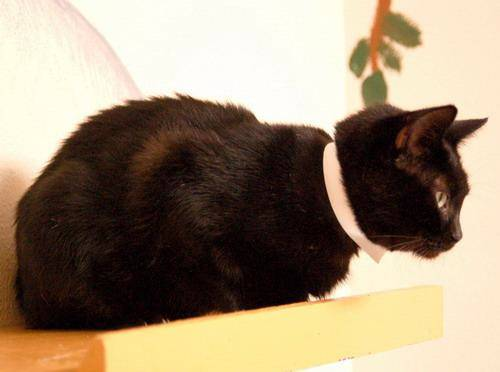

In [23]:
import random
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
%matplotlib inline
c = random.randint(0, 24999)
s = df.iloc[c]
print("目標:", s["target"])
img = load_img(s["path"])
print("維度:", img.size)
img

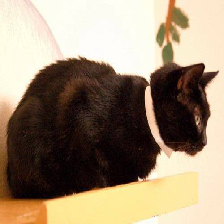

In [24]:
# 之所以要壓縮 是因為keras的input在建立模型的時候就要確定大小
load_img(s["path"], target_size=(224, 224))

In [25]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
for l in vgg.layers:
    l.trainable = False
# 眼睛和腦袋的血管，再次正規化以防止，微分時下降時落入死亡區"0"
x = BatchNormalization()(vgg.output)
# Flattern() -> 流程 # Flatten()(vgg.output) -> 流程
x = Flatten()(x)
x = Dense(units=2048, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(units=256, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(units=2, activation="softmax")(x)
cnn = Model(inputs=vgg.input, outputs=x)
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [26]:
# 二分:binary_crossentropy
# 多元:categorical_crossentropy
cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [27]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df["path"], df["target"], test_size=0.1)

In [28]:
import numpy as np
# 如果是numpy的randint, 第二個數字是不包含的
np.random.randint(0, x_train.shape[0], 10)

array([22151, 13357,  1903,  3288,  1211,  4970, 11505,   130, 18427,
       21875])

In [30]:
from keras.applications.vgg16 import preprocess_input
preprocess_input(np.array(load_img("train\cat.0.jpg")))

array([[[ -16.939003 ,   47.221    ,   79.32     ],
        [ -16.939003 ,   47.221    ,   79.32     ],
        [ -15.939003 ,   48.221    ,   80.32     ],
        ...,
        [  18.060997 ,   84.221    ,  116.32     ],
        [  17.060997 ,   83.221    ,  115.32     ],
        [  16.060997 ,   82.221    ,  114.32     ]],

       [[ -16.939003 ,   47.221    ,   79.32     ],
        [ -16.939003 ,   47.221    ,   79.32     ],
        [ -15.939003 ,   48.221    ,   80.32     ],
        ...,
        [  19.060997 ,   85.221    ,  117.32     ],
        [  18.060997 ,   84.221    ,  116.32     ],
        [  16.060997 ,   82.221    ,  114.32     ]],

       [[ -16.939003 ,   47.221    ,   79.32     ],
        [ -16.939003 ,   47.221    ,   79.32     ],
        [ -15.939003 ,   48.221    ,   80.32     ],
        ...,
        [  19.060997 ,   85.221    ,  117.32     ],
        [  18.060997 ,   84.221    ,  116.32     ],
        [  17.060997 ,   83.221    ,  115.32     ]],

       ...,

      

In [31]:
# 之所以這麼麻煩, 是因為現實的圖片太大, 沒辦法直接使用fit
from keras.applications.vgg16 import preprocess_input
from keras.utils import np_utils
train_times = 5
batch = 10
# 決定訓練次數
for i in range(train_times):
    # 隨機出一組(10)的隨機數
    idx = np.random.randint(0, x_train.shape[0], batch)
    # 把你隨機的x, y挑出來
    x = x_train.iloc[idx]
    y = y_train.iloc[idx]
    # 把image真正的讀取出來
    img_list = []
    for single_x in x:
        # X(圖片): 預處理請一定用內建預處理(keras....vgg16的preprocess_input)
        img = np.array(load_img(single_x, target_size=(224, 224)))
        img = preprocess_input(img)    
        img_list.append(img)
    # y(標籤): One-Hot
    y_cat = np_utils.to_categorical(y)
    # 自己批次訓練
    result = cnn.train_on_batch(np.array(img_list), y_cat)
    print(result)

[1.1635376, 0.5]
[8.709238, 0.3]
[1.0647037, 0.8]
[1.2577977, 0.7]
[2.6374373, 0.8]


In [27]:
idx = np.random.randint(0, x_test.shape[0], 20)
# 把你隨機的x, y挑出來
x = x_test.iloc[idx]
y = y_test.iloc[idx]
img_list = []
for single_x in x:
    # X(圖片): 預處理請一定用內建的預處理(keras....vgg16的preprocess_input)
    img = np.array(load_img(single_x, target_size=(224, 224)))
    img = preprocess_input(img)    
    img_list.append(img)
# y(標籤): One-Hot
y_cat = np_utils.to_categorical(y)
cnn.evaluate(np.array(img_list), y_cat)

20/20 [==============================] - 4s 225ms/step


[2.4246394634246826, 0.8500000238418579]

In [28]:
#存結果
cnn.save("result.h5")

In [29]:
from keras.models import load_model
load_cnn = load_model("result.h5")
load_cnn.summary()
# compile -> evaluate

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________